# Fractional Cover

* **Products used:** 
[fc_ls](https://explorer.digitalearth.africa/fc_ls), 
[wofs_ls](https://explorer.digitalearth.africa/wofs_ls)


### Background

The Fractional Cover (FC) product provides estimates of the proportions of green vegetation, non-green vegetation (including deciduous trees during autumn, dry grass, etc.), and bare soils for every Landsat pixel. Fractional cover provides valuable information for a range of environmental and agricultural applications, including:

* soil erosion monitoring
* land surface process modelling
* land management practices (e.g. crop rotation, stubble management, rangeland management)
* vegetation studies
* fuel load estimation
* ecosystem modelling
* land cover mapping

The algorithm is developed by the [Joint Remote Sensing Research Program](https://www.jrsrp.org.au/) (JRSRP) and is described in Scarth et al. (2010). Field data collected across Australia have been used to calibrate and validate the unmixing model. More information on the product can be found [here](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Seasonal+Fractional+Cover).

**Reference**

Scarth, P, Roder, A and Schmidt, M 2010, 'Tracking grazing pressure and climate interaction - the role of Landsat fractional cover in time series analysis', Proceedings of the 15th Australasian Remote Sensing & Photogrammetry Conference (ARSPC), 13-17 September, Alice Springs, Australia. Alice Springs, NT.



## Description

This notebook will cover following topics:

1. Inspecting the products and measurements available in the datacube
2. Loading pre-generated FC data.
3. Cloud and water masking FC with Water Observations from Space (WOfS) Feature Layers
4. Plotting fractional cover
5. Inspecting unmixing error outputs
6. Conducting a simple analysis workflow with FC


***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

The two sections below, "Loading, masking and visualizing pre-generated FC data" and "Calculating FC from Sentinel-2 surface reflectance" can be run independently.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_geomedian
from datacube.utils import masking
from fc.fractional_cover import compute_fractions

from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.datahandling import load_ard


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='fractional_cover')

### Analysis parameters

This section defines the analysis parameters, including 

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `time_period`: time period to be investigated
* `output_crs`: projection for loading data; output resolution is not defined so different resolutions can be used for Landsat and Sentinel-2

The default location is an area along Dawa river on the Ethiopia-Kenya border.

Default resolution, spatial and temporal extents are chosen to limit the time required for calculating FC from Sentinel-2 surface reflectance.

In [3]:
lat, lon = -31.5374, 18.2722 #3.9779, 41.6454

buffer_lat, buffer_lon = 0.03, 0.03

time_period = ('2017-01', '2017-10')

output_crs = 'epsg:6933'

#join lat,lon,buffer to get bounding box
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(lon_range, lat_range)

## List products available in Digital Earth Africa

We can use datacube's `list_products` functionality to inspect the Fractional Cover products that are available. The table below shows the product name that we will use to load data.

In [5]:
dc_measurements = dc.list_measurements()
dc_measurements.loc[['fc_ls']]

name  dtype    units  nodata      aliases flags_definition
product measurement                                                           
fc_ls   bs            bs  uint8  percent   255.0       [bare]              NaN
        pv            pv  uint8  percent   255.0  [green_veg]              NaN
        npv          npv  uint8  percent   255.0   [dead_veg]              NaN
        ue            ue  uint8        1   255.0        [err]              NaN

## Loading pre-generated fractional cover data

FC has been calculated from Landsat Collection 2 surface reflectance, at 30 m spatial resolution. FC is generated from Landsat satellites 5, 7 and 8. Their data is combined into one product called `'fc_ls'`.

In [6]:
#generate a query object from the analysis parameters
query = {
    'time': time_period,
    'x': lon_range,
    'y': lat_range,
    'output_crs': output_crs
}

In [7]:
# load all available fc data
fc = dc.load(product='fc_ls',
             resolution=(-30, 30),
             collection_category='T1',
             **query)
print(fc)

<xarray.Dataset>
Dimensions:      (time: 46, x: 194, y: 219)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:41:12.785718 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    bs           (time, y, x) uint8 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
    pv           (time, y, x) uint8 82 82 82 82 82 82 ... 255 255 255 255 255
    npv          (time, y, x) uint8 22 22 22 22 22 22 ... 255 255 255 255 255
    ue           (time, y, x) uint8 6 6 6 6 6 6 6 ... 255 255 255 255 255 255
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Cloud and water masking FC with Water Observations from Space (WOfS) Feature Layers

The unmixing algorithm breaks down when water or cloud is present. The `Water Observations Feature Layer` can be used to exclude these problematic pixels. For more information on bitmasking, see the [Applying WOfS bitmasking notebook](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb).

In [8]:
# load WOFLs from the same spatio-temporal extent
wofls = dc.load(product='wofs_ls',
                like=fc.geobox, #match extent of fc
                time=query['time'],
                collection_category='T1')

print(wofls)

<xarray.Dataset>
Dimensions:      (time: 46, x: 194, y: 219)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:41:12.785718 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    water        (time, y, x) uint8 64 64 64 64 64 64 64 64 ... 1 1 1 1 1 1 1 1
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


### Make a clear (no-cloud) and dry (no-water) pixel mask

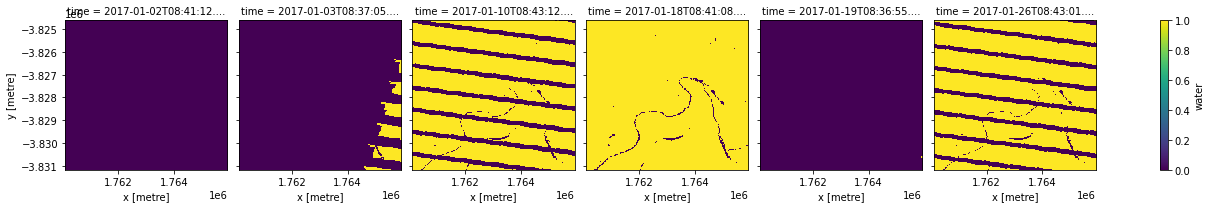

In [9]:
clear_and_dry = masking.make_mask(wofls, dry=True).water

#plot a subset of masks
clear_and_dry.isel(time=[0,1,2,3,4,5]).plot.imshow(col='time',col_wrap=6);

If we like, we can keep mostly clear scenes by calculating the number of good pixels per scene and applying a threshold

* `min_gooddata`: minimum fraction of good data required for a (FC or surface reflectance) scene to be kept

In [10]:
#set a good data fraction
min_gooddata = 0.95

#keep only the images that are at least as clear as min_gooddata
good_slice = clear_and_dry.mean(['x','y']) >= min_gooddata

Now we can apply the "clear mask" and filter to just the scenes that are mostly free of cloud and water

In [11]:
fc_clear = fc.where(clear_and_dry).isel(time=good_slice)
print(fc_clear)

<xarray.Dataset>
Dimensions:      (time: 10, x: 194, y: 219)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-18T08:41:08.825013 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    bs           (time, y, x) float64 63.0 64.0 61.0 64.0 ... 64.0 68.0 68.0
    pv           (time, y, x) float64 2.0 0.0 0.0 2.0 0.0 ... 1.0 7.0 5.0 6.0
    npv          (time, y, x) float64 34.0 35.0 38.0 33.0 ... 27.0 25.0 25.0
    ue           (time, y, x) float64 6.0 6.0 6.0 6.0 6.0 ... 5.0 6.0 7.0 7.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Plotting fractional cover


<img align="right" src="../Supplementary_data/Fractional_cover/fc_legend.jpg">

We can plot each FC variable in our dataset (i.e. `['bs', 'pv', 'npv']`) using the `rgb` function. This will create a false colour view of the data where shades of green, blue and red represent varying proportions of vegetation and bare soil cover:

* Green: photosynthetic (green) vegetation (`'pv'`)
* Blue: non-photosynthetic (i.e. 'non-green') vegetation (`'npv'`)
* Red: bare soil (`'bs'`)

The chart on the right indicates how the RGB colour composition can be interpreted. 

In the area of interest used here, the resulting images show agricultural fields containing high proportions of green vegetation cover, surrounded by areas dominated by brown vegetation and bare soil. 


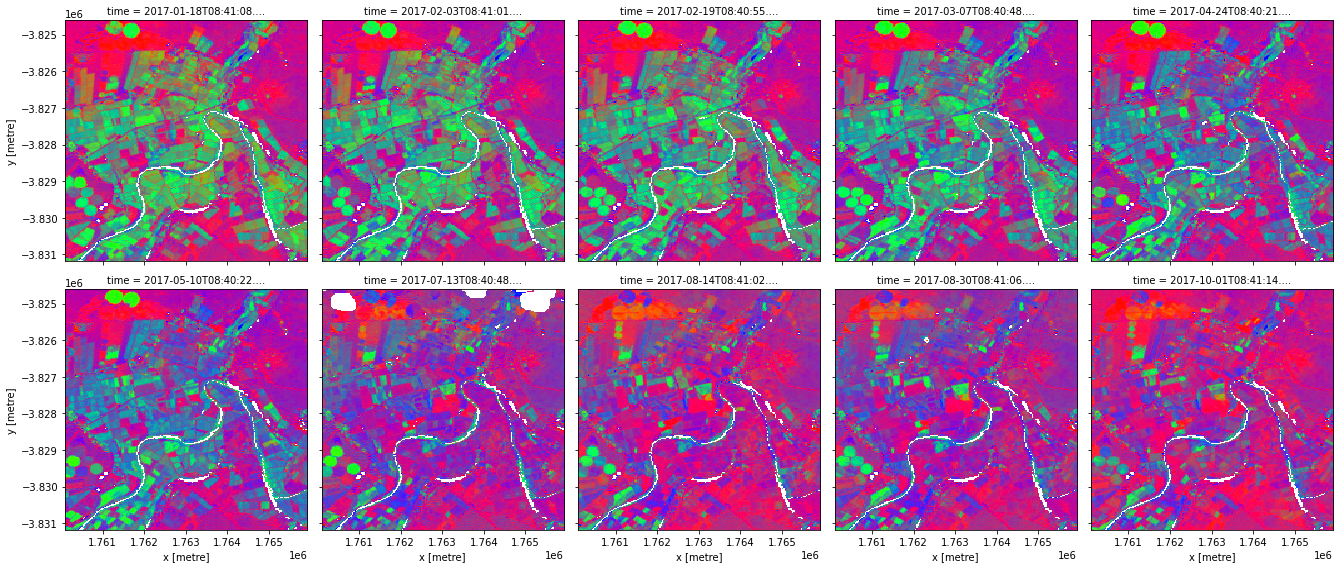

In [12]:
rgb(fc_clear,
    col='time',
    bands=['bs','pv','npv'],
    col_wrap=5,
    size=4)

## Inspecting unmixing error

Fractional cover values range between 0 and 100 %, but due to model uncertainties and the limitations of the training data, some areas may show cover values in excess of 100%. These areas can either be excluded or treated as equivalent to 100%.

We can also visualise the 'unmixing error' (ue) for each of our Fractional Cover observations. High unmixing error values (bright colours below) represent areas of higher model uncertainty (e.g. areas of water, cloud we missed masking, or soil types/colours that were not included in the model training data). This data can be useful for removing uncertain pixels from an analysis.

In this example, wet pixels associated with the river and the irrigated paddocks have relatively high unmixing errors.  Additional filtering can be done by requiring the sum of the three fractions to be close to 100 % and/or the unxming error to be small.  However, these constraints alone are not sufficient to exclude all problematic FC results. 


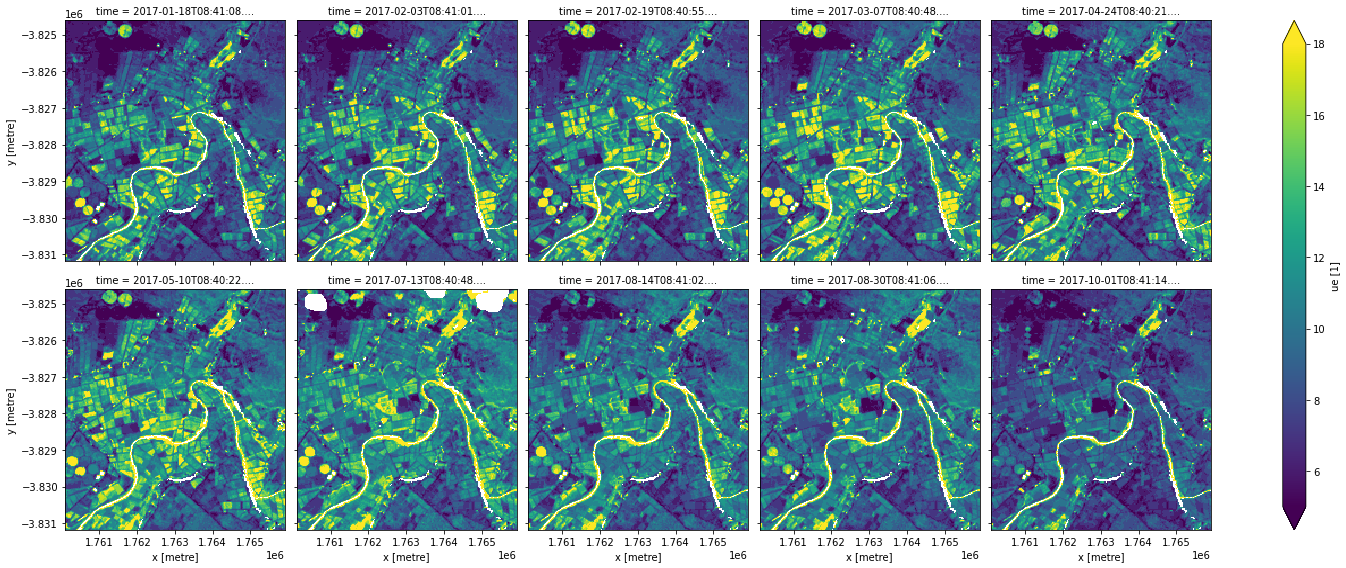

In [13]:
# Plot unmixing error using `robust=True` to drop outliers and improve contrast
fc_clear.ue.plot(col='time', robust=True, col_wrap=5, size=4);

## Example application: tracking changes in vegetation cover and bare soil over time

The following section will demonstrate a simple analysis workflow based on Fractional Cover. In this example, we will process our loaded FC data so that we can consistently track the changing proportions of green vegetation, brown vegetation and bare soil over time.

The first step is to load FC, and then mask water and clouds, and then filter to images that are mostly clear. Fortunately, we have already done this above. We will print our data `fc_clear` again to remind ourselves of the datasets contents

In [14]:
print(fc_clear)

<xarray.Dataset>
Dimensions:      (time: 10, x: 194, y: 219)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-18T08:41:08.825013 ... 2017-10...
  * y            (y) float64 -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 1.76e+06 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 6933
Data variables:
    bs           (time, y, x) float64 63.0 64.0 61.0 64.0 ... 64.0 68.0 68.0
    pv           (time, y, x) float64 2.0 0.0 0.0 2.0 0.0 ... 1.0 7.0 5.0 6.0
    npv          (time, y, x) float64 34.0 35.0 38.0 33.0 ... 27.0 25.0 25.0
    ue           (time, y, x) float64 6.0 6.0 6.0 6.0 6.0 ... 5.0 6.0 7.0 7.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Calculating average fractional cover over time

Now that our FC data has had nodata values and cloud, shadow and water pixels set to NaN, we can reliably track how average proportions of green and brown vegetation and bare soil have changed over time across our entire study area. We can then plot this as a line chart, showing that green vegetation (`pv`) has consistently decreased over time at this location, while bare soil (`bs`) has increased, and non-photosynthetic (`npv`) vegetation has been relatively stable.


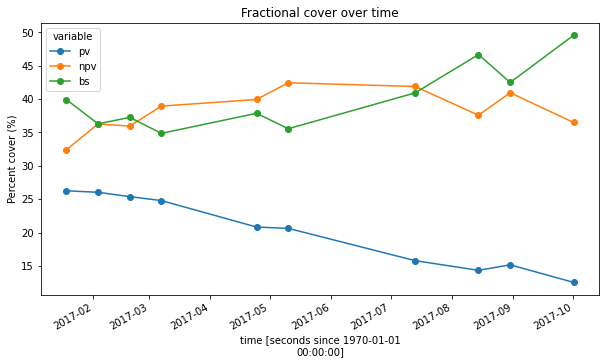

In [15]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time
fc_through_time = fc_clear[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', figsize=(10,5), marker='o')
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [16]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-16'